# Carbon fluxes

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr

from dask.distributed import Client

import catalog
import util

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools

xr.set_options(keep_attrs=True)

/glade/work/kristenk/miniconda/envs/cesm-exp/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Parameters

In [3]:
# Parameters
casename = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.scope_v1'
component = 'pop'
stream = 'h'

cluster_scheduler_address = None

In [4]:
assert component in ['pop']
assert stream in ['h', 'h.ecosys.nday1']

### Connect to cluster

In [5]:
if cluster_scheduler_address is None:
    cluster, client = util.get_ClusterClient()
    cluster.scale(12)
else:
    client = Client(cluster_scheduler_address)
client

/glade/work/kristenk/miniconda/envs/cesm-exp/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32924 instead
  f"Port {expected} is already in use.\n"


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/32924/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/32924/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.54:45247,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/32924/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Load the data

In [6]:
dsets = catalog.to_dataset_dict(
    case=casename,
    component=component,
    stream=stream,
)
dsets.keys()

dict_keys(['g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.scope_v1.pop.h'])

In [7]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons = ds_grid.TLONG
lats = ds_grid.TLAT
depths = ds_grid.z_t * 0.01

### Compute long-term mean

In [8]:
ds = dsets[f'{casename}.{component}.{stream}']

In [9]:
variables =['FG_CO2','photoC_TOT_zint','POC_FLUX_100m']
keep_vars=['z_t','z_t_150m','dz','time_bound','TAREA','TLAT','TLONG'] + variables
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

In [10]:
dt_wgt = ds.time_bound.diff('d2').squeeze()
dt_wgt /= dt_wgt.sum()
#dt_wgt

<xarray.DataArray 'time_bound' (time: 120)>
dask.array<truediv, shape=(120,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Dimensions without coordinates: time
Attributes:
    long_name:  boundaries for time-averaging interval
    units:      days since 0000-01-01 00:00:00

In [11]:
ds = ds.weighted(dt_wgt).mean('time')

### Do some global integrals

In [14]:
ds_glb = util.global_mean(ds, ds_grid, variables,normalize=False).compute()

nmols_to_PgCyr = 1e-9 * 12. * 1e-15 * 365. * 86400.

for v in variables:
    ds_glb[v] = ds_glb[v] * nmols_to_PgCyr        
    ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'
    
ds_glb

<xarray.Dataset>
Dimensions:          ()
Data variables:
    FG_CO2           float64 0.3532
    photoC_TOT_zint  float64 52.95
    POC_FLUX_100m    float64 6.654

### Make some maps

In [15]:
### convert from mmol/m3 cm/s to mmol/m2/d
for var in variables:
    ds[var] = ds[var] * 0.01 * 86400.

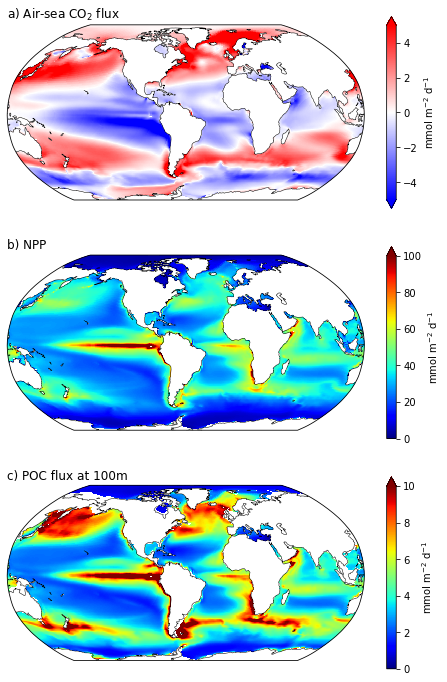

In [17]:
fig = plt.figure(figsize=(8,12))

ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('a) Air-sea CO$_2$ flux', fontsize=12,loc='left')
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds.FG_CO2)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-5,vmax=5,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='mmol m$^{-2}$ d$^{-1}$')


ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('b) NPP', fontsize=12,loc='left')
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds.photoC_TOT_zint)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='mmol m$^{-2}$ d$^{-1}$')

ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('c) POC flux at 100m', fontsize=12,loc='left')
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds.POC_FLUX_100m)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='mmol m$^{-2}$ d$^{-1}$');